In [29]:
from pennylane import qaoa
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

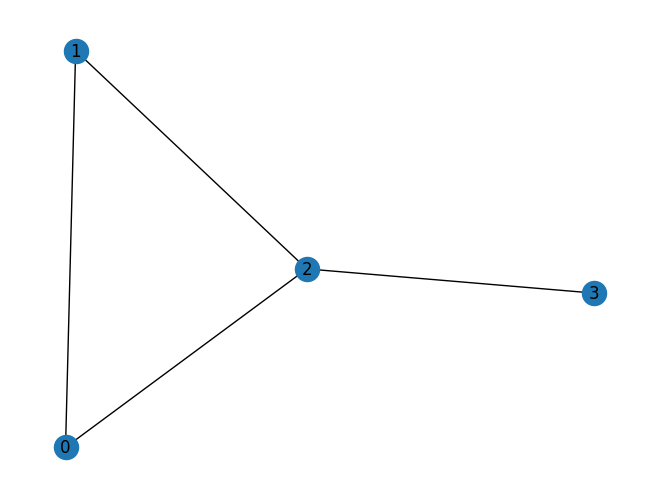

In [30]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [31]:
optimizer = qml.GradientDescentOptimizer()
steps = 20
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

In [32]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [33]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [34]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [35]:
from functools import partial

dev = qml.device("default.qubit", wires=4, shots=1000)

#@partial(qml.cut_circuit, auto_cutter=True)  # auto_cutter enabled
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)


for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step", i, "Cost", cost_function(params))

print("Optimal Parameters")
print(params)

Step 0 Cost 1.218
Step 1 Cost 0.44499999999999995
Step 2 Cost -0.17800000000000002
Step 3 Cost -0.499
Step 4 Cost -0.5880000000000001
Step 5 Cost -0.723
Step 6 Cost -0.9020000000000001
Step 7 Cost -0.944
Step 8 Cost -0.971
Step 9 Cost -1.114
Step 10 Cost -1.1360000000000001
Step 11 Cost -1.284
Step 12 Cost -1.316
Step 13 Cost -1.418
Step 14 Cost -1.4629999999999999
Step 15 Cost -1.594
Step 16 Cost -1.49
Step 17 Cost -1.536
Step 18 Cost -1.43
Step 19 Cost -1.453
Step 20 Cost -1.5950000000000002
Step 21 Cost -1.5670000000000002
Step 22 Cost -1.5760000000000003
Step 23 Cost -1.508
Step 24 Cost -1.6
Step 25 Cost -1.551
Step 26 Cost -1.5160000000000002
Step 27 Cost -1.4729999999999999
Step 28 Cost -1.6430000000000002
Step 29 Cost -1.577
Step 30 Cost -1.462
Step 31 Cost -1.592
Step 32 Cost -1.6169999999999998
Step 33 Cost -1.538
Step 34 Cost -1.484
Step 35 Cost -1.6099999999999999
Step 36 Cost -1.524
Step 37 Cost -1.516
Step 38 Cost -1.5610000000000002
Step 39 Cost -1.568
Step 40 Cost -1.645

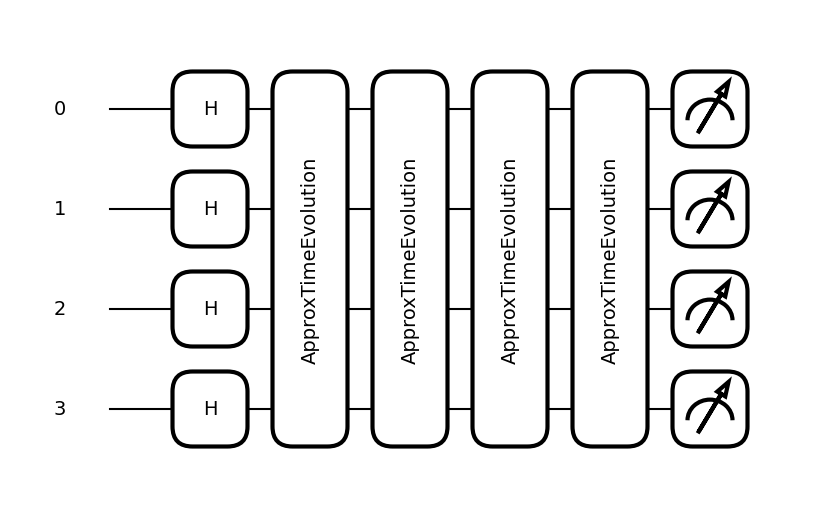

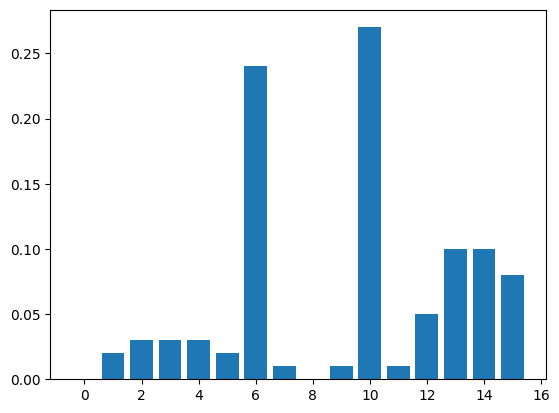

In [36]:
dev = qml.device("default.qubit", wires=wires, shots=100)

@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])
qml.draw_mpl(probability_circuit)(params[0], params[1])
plt.show()
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [37]:
from functools import partial

#params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

dev = qml.device("lightning.qubit", wires=3, shots=1000)

@partial(qml.cut_circuit, auto_cutter=True)
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

res = cost_function(params)

print("Optimal Parameters")
print(params)

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (53).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (52).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


Optimal Parameters
[[0.5954    0.9415775]
 [0.52599   0.85372  ]]


In [38]:
dev = qml.device("lightning.qubit", wires=3, shots=1000)

#params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

@partial(qml.cut_circuit_mc, auto_cutter=True)
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.sample(wires=range(4))

res2 = cost_function(params)
res2

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (55).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


array([[0., 0., 0., 1.],
       [0., 1., 0., 1.],
       [1., 1., 1., 0.],
       ...,
       [1., 0., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 1., 0.]])

In [39]:
print(len(res2))

1000


Probability of measuring each state: [0.053, 0.061, 0.056, 0.078, 0.066, 0.065, 0.053, 0.06, 0.071, 0.044, 0.083, 0.056, 0.076, 0.064, 0.053, 0.061]


<BarContainer object of 16 artists>

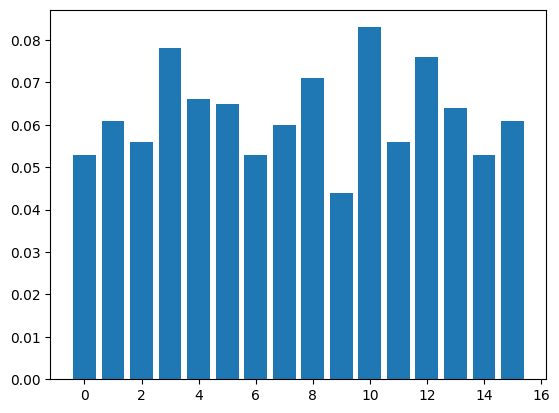

In [40]:
n_qubit = 4

bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]

probs = []

str_res = []

for r in res2:
    str_res.append("".join([str(int(i)) for i in r]))

for b in bitstrings:
    probs.append(str_res.count(b) / len(res2))

print(f"Probability of measuring each state: {probs}")
plt.bar(range(2 ** n_qubit), probs)

In [41]:
print(res)

-1.5155218008750015


In [42]:

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step", i, "Cost", cost_function(params))

print("Optimal Parameters")
print(params)

AttributeError: 'SequenceBox' object has no attribute 'flatten'

In [ ]:
from functools import partial

n_qubit = 4

dev = qml.device("default.qubit", wires=4, shots=1000)

@partial(qml.cut_circuit_mc, auto_cutter=True)  # auto_cutter enabled
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.sample(wires=wires)

res = probability_circuit(params[0], params[1])

bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]

probs = []

str_res = []

for r in res:
    str_res.append("".join([str(int(i)) for i in r]))

for b in bitstrings:
    probs.append(str_res.count(b) / len(res))

print(f"Probability of measuring each state: {probs}")
plt.bar(range(2 ** n_qubit), probs)

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (55).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


KeyboardInterrupt: 